# Setup

## Imports

In [13]:
import os
from pprint import pprint

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchsummary import summary

from pkgs.utils import config_system

## Load configs

In [2]:
paths_dict = config_system.load_paths_config()
pprint(paths_dict)

{'audio_config_file': '/home/amar/projects/audino/configs/audio.yml',
 'books_config_file': '/home/amar/projects/audino/configs/books.yml',
 'configs_dir': '/home/amar/projects/audino/configs',
 'data_dir': '/home/amar/projects/audino/data',
 'datasets_dir': '/home/amar/projects/audino/datasets',
 'firebase_config_file': '/home/amar/projects/audino/configs/firebase_config.yml',
 'paths_config_file': '/home/amar/projects/audino/configs/paths.yml',
 'project_root': '/home/amar/projects/audino',
 'summary_config_file': '/home/amar/projects/audino/configs/summary.yml'}


# Data cleanliness check

In [3]:
# Load data
full_data_path = os.path.join(paths_dict['datasets_dir'], 'processed', 'concat_data_raw.csv')
full_df = pd.read_csv(full_data_path)
full_df.head()

,dataset_name,gender,emotion,emotional_intensity,text,audio_file_name,actor
0,RAVDESS,male,sad,medium,Dogs are sitting by the door,03-01-04-01-02-02-13.wav,ravdess_13
1,RAVDESS,male,calm,medium,Dogs are sitting by the door,03-01-02-01-02-02-13.wav,ravdess_13
2,RAVDESS,male,sad,medium,Kids are talking by the door,03-01-04-01-01-01-13.wav,ravdess_13
3,RAVDESS,male,neutral,medium,Dogs are sitting by the door,03-01-01-01-02-02-13.wav,ravdess_13
4,RAVDESS,male,sad,high,Kids are talking by the door,03-01-04-02-01-02-13.wav,ravdess_13


In [4]:
full_df.shape

(11682, 7)

## Value counts

In [7]:
full_df['dataset_name'].value_counts()

CREMA      7442
TESS       2800
RAVDESS    1440
Name: dataset_name, dtype: int64

In [8]:
full_df['gender'].value_counts()

female    7032
male      4650
Name: gender, dtype: int64

In [9]:
full_df['emotion'].value_counts()

sad          1863
happy        1863
fear         1863
angry        1863
disgust      1863
neutral      1583
surprised     592
calm          192
Name: emotion, dtype: int64

In [12]:
# joining neutral and calm as they are similar
full_df['emotion'].replace('calm', 'neutral', inplace=True)
full_df['emotion'].value_counts()

sad          1863
happy        1863
fear         1863
angry        1863
disgust      1863
neutral      1775
surprised     592
Name: emotion, dtype: int64

In [13]:
full_df['emotional_intensity'].value_counts()

unknown    6077
medium     4023
high       1127
low         455
Name: emotional_intensity, dtype: int64

In [14]:
full_df['text'].value_counts()

It's eleven'o clock               1456
Dogs are sitting by the door       720
Kids are talking by the door       720
I would like a new alarm clock     546
The airplane is almost full        546
                                  ... 
say the word ditch                  14
say the word witch                  14
say the word cool                   14
say the word juice                  14
say the word nag                    14
Name: text, Length: 214, dtype: int64

In [15]:
full_df['actor'].value_counts()

tess_young    1401
tess_old      1399
crema_06        82
crema_30        82
crema_80        82
              ... 
ravdess_03      60
ravdess_16      60
ravdess_22      60
ravdess_15      60
ravdess_13      60
Name: actor, Length: 117, dtype: int64

# Architecture study

In [ ]:
# Our architecure closely follows the following paper:
# Transfer Learning from Speaker Verification to Multispeaker Text-To-Speech Synthesis
'''
They have 3 blocks in their architecture
1. Speaker encoder
    > The speaker encoder is used to create a fixed size embedding for the speaker. It aims to capture the features of a speaker
    > This speaker encoder is trained as a speaker-discriminative model on text-independent speaker verification task
    > The network maps a (sequence of log-mel spectogram frames) computed from a speech utterance of arbitrary length to a (fixed-dimensional vector)
    > Trained on GE2E loss
    > Training dataset consists of speech audio samples segmented into 1.6 seconds and associated speaker identity labels
    > Input 40-channel log-mel spectograms are passed to the network
    > During inference an arbitrary length utterance is broken into 800ms windows overlapped by 50%. The network is run independently on each window and outputs are averaged
    > Final map: Not my problem because no retraining is required here
2. Synthesizer
    > Extension of the Tacotron 2 architecture
    > An embedding vector for the speaker calculated from the speaker encoder is concatenated with the synthesizer encoder output at each time step
    > Trained on pairs of text transcripts and target audio
    > At the input the text is mapped to a sequence of phonemes
    > At the output we give mel spectogram features
    > The features are computed from 50ms windows with a step size of 12.5ms passed through an 80-channel mel-scale filterbank followed by log dynamic range compression
    > Final map:
        Input: Text is converted to a seq of phonemes
        Output: A spectogram for the audio clip broken down into 50ms windows with step size 12.5ms converted to 80-channel mel-scale filterbank followed by ...
3. Vocoder
    > Implemented by WaveNet
    > Takes mel spectograms as input and returns speech 
    > Final map: Not my problem because no retraining is required here
4. Prosody encoder
    > This component is our addition.
    > The data for this is stored in the processed dir
    > This data should be used to fine-tune the synthesizer component from the (text, audio) pairs collected. Make small changes only
    > The encoder has to learn 5 emotions and this should be a lookup table as no new emotions are to be inferenced. The paper mentions something similar in [8][13]
    > These learned embeddings are also concatenated with the encoder output at each time step along with the speaker embedding.
    > Final map: 
        Gotta learn this from [8][13]
'''

## Mel spectograms

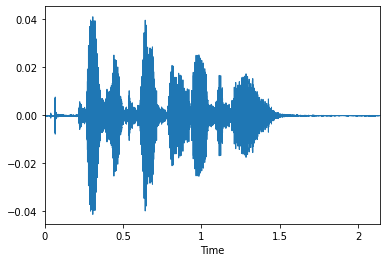

In [22]:
# Input: 40 channel log-mel spectogram (generated from the utterance)
# Output: (a d-dimensional vector) 
filename = '/home/amar/projects/audino/datasets/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'

# y is a 1-d array because the audio was changed to mono and sr is the sampling rate 
y, sr = librosa.load(filename)

# trimming the silence in the beginning and end. audio is a 1-d array and index is the ending index of the leading trim, starting index of the trailing trim
audio, index = librosa.effects.trim(y)

librosa.display.waveplot(audio, sr=sr)

<class 'numpy.ndarray'> (33, 1) float32


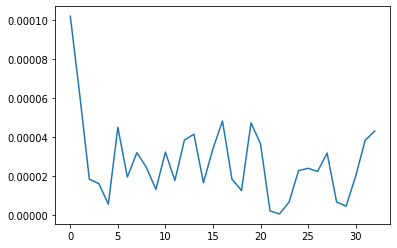

In [41]:
# Fourier transform
n_fft = 64
D = np.abs(librosa.stft(audio[:n_fft], n_fft=n_fft, hop_length=n_fft+1) )
print(type(D), D.shape, D.dtype)
plt.plot(D)

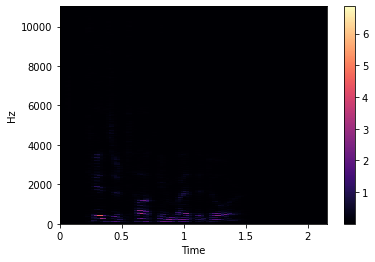

In [53]:
# Fourier transform for the complete audio
hop_length = 512
D = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar();

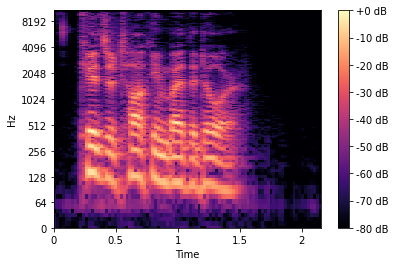

In [47]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

In [57]:
# Mel scale
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
type(mel), mel.shape

/home/amar/projects/audino/env/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


(numpy.ndarray, (128, 33))

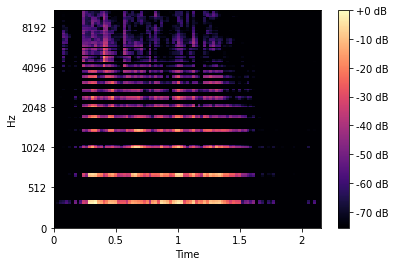

In [61]:
# Mel spectogram
S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

(numpy.ndarray, (256, 99))

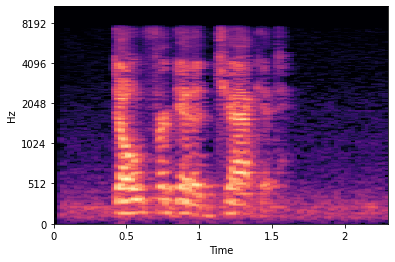

In [83]:
# Mel spectograms continued...
def get_mel_spectogram(audio_file_path, n_fft=2048, hop_length=512, n_mels=128):
    audio, sr = librosa.load(audio_file_path)
    S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    return S_DB

audio_file = '/home/amar/projects/audino/datasets/CREMA-D/1001_DFA_ANG_XX.wav'
s = get_mel_spectogram(audio_file, n_mels=256)
type(s), s.shape

In [ ]:
# n_mels is the n-channel in n-channel mel spectogram
# n_fft is the mel window length
# hop_length is the window step
# the function returns librosa.feature.melspectrogram returns frames
# Note: this is not log-mel spectograms only mel spectograms

# Component architecure and weights

## Speaker encoder

In [25]:
# Load the components of the current architecture from the model files stored in pretrained dir
encoder_pretrained_path = '/home/amar/projects/audino/pretrained/encoder/saved_models/pretrained.pt'
weights_dict = torch.load(encoder_pretrained_path, map_location=torch.device('cpu'))

In [26]:
# CJ's class implementation
class SpeakerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.loss_device = loss_device
        
        # Network defition
        self.lstm = nn.LSTM(input_size=40,
                            hidden_size=256, 
                            num_layers=3, 
                            batch_first=True)
        self.linear = nn.Linear(in_features=256, 
                                out_features=256)
        self.relu = torch.nn.ReLU()
        
        # Cosine similarity scaling (with fixed initial parameter values)
        self.similarity_weight = nn.Parameter(torch.tensor([10.]))
        self.similarity_bias = nn.Parameter(torch.tensor([-5.]))

        # Loss
        self.loss_fn = nn.CrossEntropyLoss()

cj_model = SpeakerEncoder()

In [31]:
cj_model.load_state_dict(weights_dict['model_state'])
print(cj_model)

SpeakerEncoder(
  (lstm): LSTM(40, 256, num_layers=3, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (relu): ReLU()
  (loss_fn): CrossEntropyLoss()
)


## Synthesizer

## Vocoder